In [50]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import pyspark
from pyspark import SparkContext

from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# PCA
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier

from pyspark.sql import SparkSession
from pyspark.sql.functions import when

%matplotlib inline

In [2]:
sc = SparkContext(master = "local", appName = "Name")

spark = SparkSession.builder.appName('ml-sonar').getOrCreate()

In [8]:
data_path = "/home/nareg/Desktop/Data Science/Deep Learning/sonar.all-data"

In [36]:
df = spark.read.format("csv").option("header", "false").option("inferSchema", "true").load(data_path)

In [37]:
df = df.withColumn("_c60", when(df._c60 == "R", 0).otherwise(1))

In [38]:
cols = df.columns
cols.remove("_c60")

In [39]:
# Number of cases per class
pd.value_counts(df.toPandas()._c60)

1    111
0     97
Name: _c60, dtype: int64

In [40]:
assembler = VectorAssembler(inputCols = cols, outputCol = "features")

df = assembler.transform(df)

# PCA

In [41]:
pca = PCA(k = 13).setInputCol("features").setOutputCol("PCA_features")

df = pca.fit(df).transform(df)

In [42]:
df.select("features", "PCA_features").show(5)

+--------------------+--------------------+
|            features|        PCA_features|
+--------------------+--------------------+
|[0.02,0.0371,0.04...|[0.28941881930573...|
|[0.0453,0.0523,0....|[-1.2573410622431...|
|[0.0262,0.0582,0....|[-0.6125604941696...|
|[0.01,0.0171,0.06...|[0.56536153675332...|
|[0.0762,0.0666,0....|[-0.3514292502304...|
+--------------------+--------------------+
only showing top 5 rows



In [43]:
train, test = df.randomSplit([0.75, 0.25], seed = 420)

# Logistic Regression

In [17]:
lr = LogisticRegression(labelCol = "_c60", featuresCol = "PCA_features", maxIter = 20)

model = lr.fit(train)
predict_train = model.transform(train)
predict_test = model.transform(test)

In [18]:
predict_test.select("_c60", "prediction").show(10)

+----+----------+
|_c60|prediction|
+----+----------+
|   1|       0.0|
|   0|       0.0|
|   0|       0.0|
|   0|       0.0|
|   0|       0.0|
|   1|       1.0|
|   0|       0.0|
|   0|       0.0|
|   0|       0.0|
|   1|       1.0|
+----+----------+
only showing top 10 rows



In [19]:
print("Accuracy: ",
      np.mean(predict_test.select("_c60", "prediction").toPandas()["_c60"] == predict_test.select("_c60", "prediction").toPandas()["prediction"]))

Accuracy:  0.8035714285714286


In [20]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol = "rawPrediction", labelCol = "_c60")

predict_test.select("_c60","rawPrediction","prediction","probability").show(5)

print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train)))
print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test)))

+----+--------------------+----------+--------------------+
|_c60|       rawPrediction|prediction|         probability|
+----+--------------------+----------+--------------------+
|   1|[1.48931157795913...|       0.0|[0.81597492171628...|
|   0|[1.81787671238998...|       0.0|[0.86031115425930...|
|   0|[3.82388167817851...|       0.0|[0.97862406217445...|
|   0|[2.94563738354235...|       0.0|[0.95005689351939...|
|   0|[2.13910561911061...|       0.0|[0.89464634101337...|
+----+--------------------+----------+--------------------+
only showing top 5 rows

The area under ROC for train set is 0.8675013041210224
The area under ROC for test set is 0.8576923076923076


Area under ROC:  0.8675013041210224


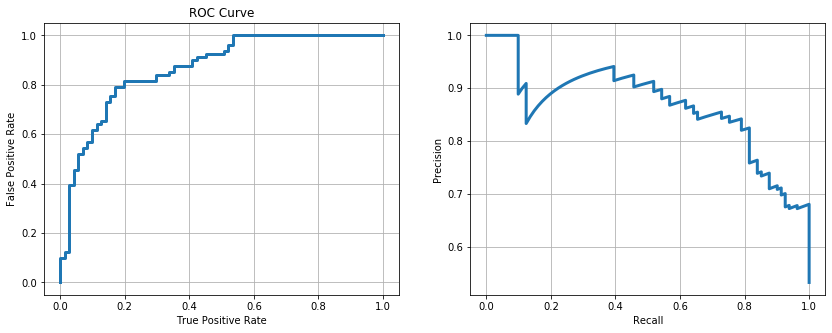

In [28]:
roc = model.summary.roc.toPandas()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 5))

ax1.plot(roc['FPR'], roc['TPR'], lw = 3)

ax1.set_xlabel('True Positive Rate')
ax1.set_ylabel('False Positive Rate')
ax1.set_title('ROC Curve')

ax1.grid()
print("Area under ROC: ", model.summary.areaUnderROC)

pr = model.summary.pr.toPandas()

ax2.plot(pr['recall'],pr['precision'], lw = 3)
ax2.set_xlabel('Recall');
ax2.set_ylabel('Precision')

ax2.grid();

---

# Decision Tree Classifier

In [29]:
dt = DecisionTreeClassifier(labelCol = "_c60", featuresCol = "PCA_features", maxDepth = 5)

model_tree = dt.fit(train)
predict_train_tree = model_tree.transform(train)
predict_test_tree = model_tree.transform(test)

In [30]:
print("Accuracy: ",
      np.mean(predict_test_tree.select("_c60", "prediction").toPandas()["_c60"] == predict_test_tree.select("_c60", "prediction").toPandas()["prediction"]))

Accuracy:  0.8392857142857143


# K-fold Cross Validation

In [120]:
paramGrid = ParamGridBuilder().addGrid(lr.aggregationDepth,[2,5,10])\
                              .addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0])\
                              .addGrid(lr.fitIntercept,[False, True])\
                              .addGrid(lr.maxIter,[5, 20, 200])\
                              .addGrid(lr.regParam,[0.01, 0.5, 2.0])\
                              .build()

In [29]:
cv_k = CrossValidator(estimator = lr, estimatorParamMaps = paramGrid, evaluator = evaluator, numFolds = 5)

model_cv = cv_k.fit(train)
predict_train_cv = model_cv.transform(train)
predict_test_cv = model_cv.transform(test)

In [30]:
print("Accuracy: ",
      np.mean(predict_test_cv.select("_c60", "prediction").toPandas()["_c60"] == predict_test_cv.select("_c60", "prediction").toPandas()["prediction"]))

Accuracy:  0.8035714285714286


In [60]:
# Intercept and coefficients
print(model_cv.bestModel.intercept)
print(model_cv.bestModel.coefficients)

-3.244902621259846
[-0.588141276337126,0.0,-0.08981904955998944,-3.989335798654114,3.6562371114627763,0.257521549841511,1.744086764115471,-0.37392972749484543,0.5711273069232807]


In [67]:
# Best hypeparameter values
model_cv.getEstimatorParamMaps()[np.argmax(model_cv.avgMetrics)]

{Param(parent='LogisticRegression_9e41c67fda76', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LogisticRegression_9e41c67fda76', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 1.0,
 Param(parent='LogisticRegression_9e41c67fda76', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LogisticRegression_9e41c67fda76', name='maxIter', doc='max number of iterations (>= 0).'): 200,
 Param(parent='LogisticRegression_9e41c67fda76', name='regParam', doc='regularization parameter (>= 0).'): 0.01}

# Random Forest Classifier

In [44]:
rf = RandomForestClassifier(featuresCol = 'PCA_features', labelCol = '_c60')

model_rf = rf.fit(train)

predict_train_rf = model_rf.transform(train)
predict_test_rf = model_rf.transform(test)

In [45]:
print("Accuracy: ",
      np.mean(predict_test_rf.select("_c60", "prediction").toPandas()["_c60"] == predict_test_rf.select("_c60", "prediction").toPandas()["prediction"]))

Accuracy:  0.8214285714285714


# Multilayer Perceptron Classifier

In [103]:
layers = [13, 26, 36, 13, 2]

perceptron = MultilayerPerceptronClassifier(maxIter = 200, layers = layers, blockSize = 128, seed = 420, 
                                            featuresCol = 'PCA_features', labelCol = '_c60')

# train the model
model_perceptron = perceptron.fit(train)

predict_train_perceptron = model_perceptron.transform(train)
predict_test_perceptron = model_perceptron.transform(test)

In [104]:
print("Accuracy: ",
      np.mean(predict_test_perceptron.select("_c60", "prediction").toPandas()["_c60"] == predict_test_perceptron.select("_c60", "prediction").toPandas()["prediction"]))

Accuracy:  0.8214285714285714


In [105]:
#predictionAndLabels = predict_train_perceptron.select("_c60", "prediction")

evaluator = BinaryClassificationEvaluator(rawPredictionCol = "rawPrediction", labelCol = "_c60",
                                          metricName = 'areaUnderROC')

print("Area Under ROC = " + str(evaluator.evaluate(predict_test_perceptron)))

Area Under ROC = 0.8256410256410257
